In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
## Getting data
df = pd.read_csv("exams.csv")

## Exploring Data

In [3]:
print(df.dtypes)
print(df.columns)

gender                         object
race/ethnicity                 object
parental level of education    object
lunch                          object
test preparation course        object
math score                      int64
reading score                   int64
writing score                   int64
dtype: object
Index(['gender', 'race/ethnicity', 'parental level of education', 'lunch',
       'test preparation course', 'math score', 'reading score',
       'writing score'],
      dtype='object')


### Categorical Variables

Column gender has 0 missing values and the value counts are:
male      508
female    492
Name: gender, dtype: int64


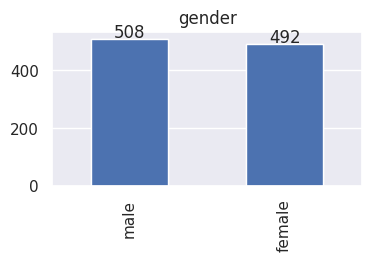

Column race/ethnicity has 0 missing values and the value counts are:
group C    323
group D    257
group B    198
group E    143
group A     79
Name: race/ethnicity, dtype: int64


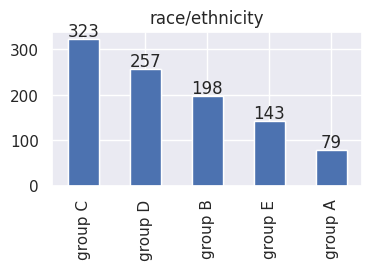

Column parental level of education has 0 missing values and the value counts are:
some college          224
high school           215
associate's degree    204
some high school      177
bachelor's degree     105
master's degree        75
Name: parental level of education, dtype: int64


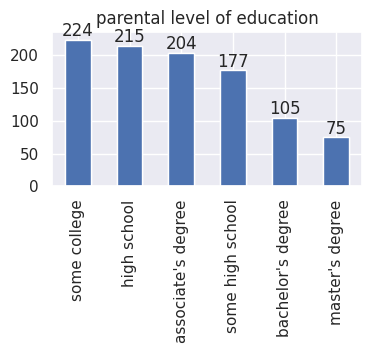

Column lunch has 0 missing values and the value counts are:
standard        660
free/reduced    340
Name: lunch, dtype: int64


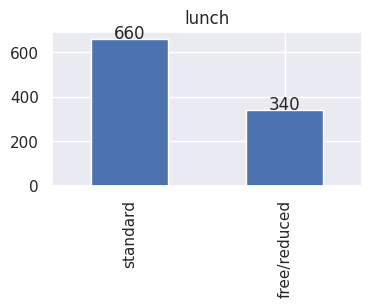

Column test preparation course has 0 missing values and the value counts are:
none         656
completed    344
Name: test preparation course, dtype: int64


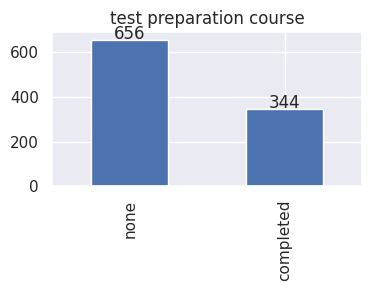

In [5]:
categorical_cols = df.select_dtypes(include=['object'])
sns.set()

for col in categorical_cols:
    na_count = df[col].isna().sum()
    value_count = df[col].value_counts(dropna=False)
    print(f"Column {col} has {na_count} missing values and the value counts are:")
    print(value_count)

    plt.figure(figsize=(4, 2))
    value_count.plot(kind='bar')
    ax = value_count.plot(kind='bar')
    ax.set_title(col)
    for i, v in enumerate(value_count):
        ax.text(i, v+5, str(v), ha='center')
    plt.show()

### Numerical Variables

In [6]:
numerical_cols = df.select_dtypes(include=['int64'])
for col in numerical_cols:
    na_count = df[col].isna().sum()
    value_count = df[col].value_counts(dropna=False)
    print(f"Column {col} has {na_count} missing values and the value counts are:")

Column math score has 0 missing values and the value counts are:
Column reading score has 0 missing values and the value counts are:
Column writing score has 0 missing values and the value counts are:


In [7]:
numerical_cols.describe()

,math score,reading score,writing score
count,1000.000000,1000.000000,1000.000000
mean,67.810000,70.382000,69.140000
std,15.250196,14.107413,15.025917
min,15.000000,25.000000,15.000000
25%,58.000000,61.000000,59.000000
50%,68.000000,70.500000,70.000000
75%,79.250000,80.000000,80.000000
max,100.000000,100.000000,100.000000


<Axes: >

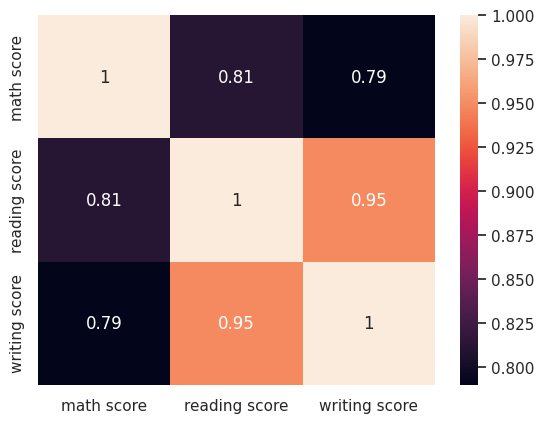

In [8]:
sns.heatmap(numerical_cols.corr(), annot=True)

## Preparing Data

In [9]:
# Select the categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns

# Define the ColumnTransformer for one-hot encoding
ct = ColumnTransformer(transformers=[('onehot', OneHotEncoder(), categorical_cols)], remainder='passthrough')

# Apply the ColumnTransformer to the data
onehot_encoded_data = ct.fit_transform(df)

# Convert the one-hot encoded data into a DataFrame with the feature names
onehot_encoded_df = pd.DataFrame(onehot_encoded_data, columns=ct.get_feature_names_out())

# Separate your feature matrix (X) and target variable (y)

X = onehot_encoded_df.drop('remainder__math score', axis=1) # select all columns except for math score
y = onehot_encoded_df['remainder__math score']



### Linear Regressor Model

In [10]:
# assume X is your feature matrix and y is your target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# instantiate a linear regression model
lr = LinearRegression()

# fit the model to the training data
lr.fit(X_train, y_train)

# predict on the test data
y_pred = lr.predict(X_test)



In [11]:

# calculate mean squared error and root mean squared error
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print('MSE:', mse)
print('RMSE:', rmse)

# calculate R-squared
r2 = r2_score(y_test, y_pred)
print('R-squared:', r2)

MSE: 24.83855821054254
RMSE: 4.9838296731070715
R-squared: 0.8874881345612098


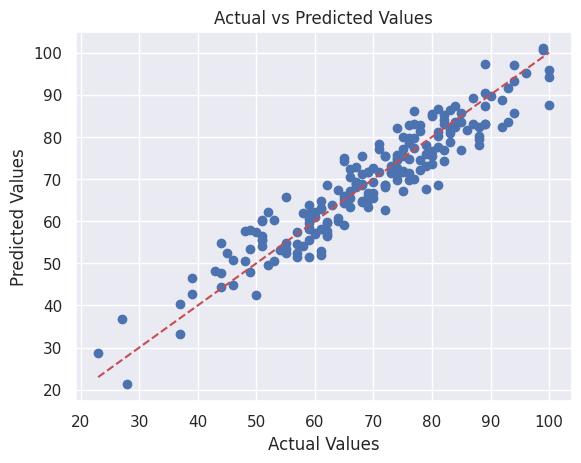

In [12]:
sns.set()
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.show()


### XGBRegressor

In [13]:
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.6, learning_rate=0.16,
                          max_depth=20, alpha=52, n_estimators=250)
xg_reg.fit(X_train, y_train)
# Make predictions on the test set
y_pred = xg_reg.predict(X_test)

# Evaluate the performance of the model using RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse))

# Evaluate the performance of the model using R-squared
r2 = xg_reg.score(X_test, y_test)
print("R-squared: %f" % (r2))


RMSE: 5.287088
R-squared: 0.873379


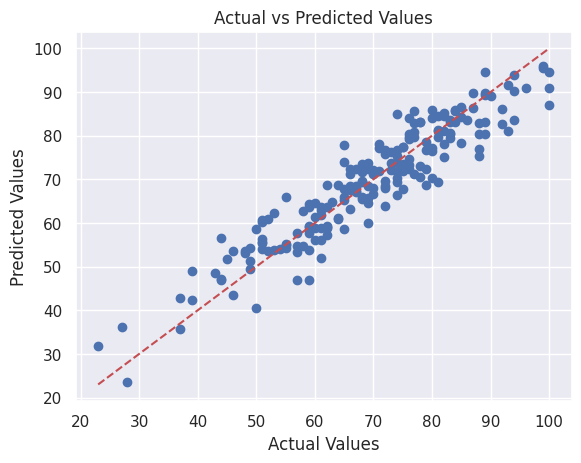

In [14]:
sns.set()
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.show()

### Tuning Hyperparameters

In [15]:
%%time

param_grid = {
    'colsample_bytree': [0.55,0.60,0.65],
    'learning_rate': [0.17, 0.16, 0.15],
    'max_depth': [20, 15,16],
    'alpha': [50,55,54,53,52],
    'n_estimators': [250, 240,260]
}
grid_search = GridSearchCV(estimator=xg_reg, param_grid=param_grid, cv=5, verbose=3 )
# Fit the grid search object to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and the corresponding score
print("Best parameters found: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Fitting 5 folds for each of 405 candidates, totalling 2025 fits
[CV 1/5] END alpha=50, colsample_bytree=0.55, learning_rate=0.17, max_depth=20, n_estimators=250;, score=0.851 total time=   0.1s
[CV 2/5] END alpha=50, colsample_bytree=0.55, learning_rate=0.17, max_depth=20, n_estimators=250;, score=0.815 total time=   0.1s
[CV 3/5] END alpha=50, colsample_bytree=0.55, learning_rate=0.17, max_depth=20, n_estimators=250;, score=0.843 total time=   0.0s
[CV 4/5] END alpha=50, colsample_bytree=0.55, learning_rate=0.17, max_depth=20, n_estimators=250;, score=0.849 total time=   0.1s
[CV 5/5] END alpha=50, colsample_bytree=0.55, learning_rate=0.17, max_depth=20, n_estimators=250;, score=0.889 total time=   0.1s
[CV 1/5] END alpha=50, colsample_bytree=0.55, learning_rate=0.17, max_depth=20, n_estimators=240;, score=0.851 total time=   0.1s
[CV 2/5] END alpha=50, colsample_bytree=0.55, learning_rate=0.17, max_depth=20, n_estimators=240;, score=0.815 total time=   0.0s
[CV 3/5] END alpha=50, col